In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960



In [3]:
# Importing libraries
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [8]:
# Path to the dataset
dataset_path = 'cifake-real-and-ai-generated-synthetic-images' 

In [9]:
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

In [10]:
# Check if paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    print("Dataset paths do not exist.")
else:
    print("Dataset Sucessfully loaded")

Dataset Sucessfully loaded


2.Preprocess the Dataset
   We'll use ImageDataGenerator to preprocess the images by rescaling and augmenting.


In [11]:
# Data preprocessing
IMG_HEIGHT = 32
IMG_WIDTH = 32
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
                          rescale=1.0/255.0,
                          rotation_range=20,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest'

)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [12]:
#Load train and test Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


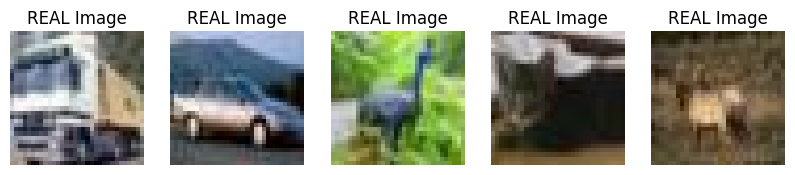

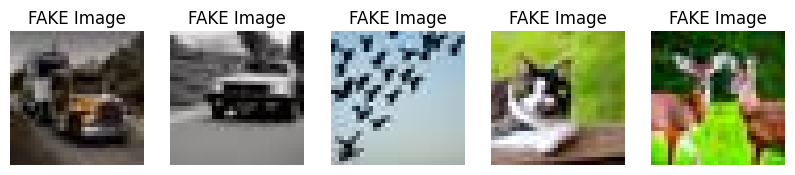

In [13]:
# Correct paths to the training and testing folders
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Function to display a grid of sample images
def visualize_sample_images(directory, class_name, num_images=5):
    class_dir = os.path.join(directory, class_name)
    image_files = os.listdir(class_dir)[:num_images]

    plt.figure(figsize=(10, 10))

    for i, image_file in enumerate(image_files):
        img_path = os.path.join(class_dir, image_file)
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)

        plt.subplot(1, num_images, i+1)
        plt.imshow(np.uint8(img_array))
        plt.title(f'{class_name} Image')
        plt.axis('off')

    plt.show()

# Example: Visualize images from both classes (REAL and FAKE)
visualize_sample_images(train_dir, 'REAL', num_images=5)
visualize_sample_images(train_dir, 'FAKE', num_images=5)

3.Build the CNN model
    We'll create a simple CNN model to classify the images.

In [14]:
def build_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

model = build_model()
model.summary()

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 689s 440ms/step - accuracy: 0.8241 - loss: 0.3915 - val_accuracy: 0.7907 - val_loss: 0.4690
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 263s 168ms/step - accuracy: 0.8550 - loss: 0.3360 - val_accuracy: 0.8092 - val_loss: 0.4626
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - accuracy: 0.8708 - loss: 0.3050 - val_accuracy: 0.8716 - val_loss: 0.3012
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 90s 57ms/step - accuracy: 0.8819 - loss: 0.2846 - val_accuracy: 0.8086 - val_loss: 0.4653
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 53ms/step - accuracy: 0.8891 - loss: 0.2682 - val_accuracy: 0.8666 - val_loss: 0.3307
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 53ms/step - accuracy: 0.8941 - loss: 0.2576 - val_accuracy: 0.8130 - val_loss: 0.4742
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - accuracy: 0.8981 - loss: 0.2507 - val_accuracy: 0.8498 - val_loss: 0.3807
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - accuracy: 0.8

Evaluate the model 

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy of Model is: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8944 - loss: 0.2480
Test accuracy of Model is: 0.8921499848365784


Save the model

In [51]:
model.save('real_vs_fake_image_classifier.h5')

Predict with the model

In [47]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_img(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        print("Image is Real")
    else:
        print("Image is AI Generated")

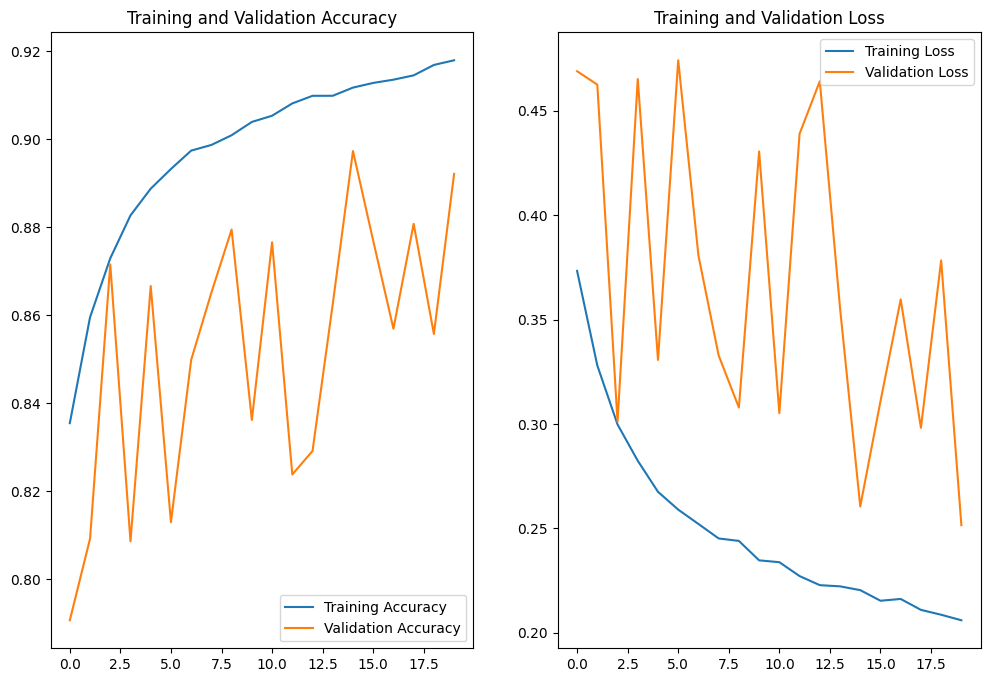

In [21]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
%%writefile app.py
from PIL import Image
import numpy as np
import streamlit as st
from tensorflow.keras.models import load_model


IMG_HEIGHT = 32  # Set to the size expected by the model
IMG_WIDTH = 32

def predict_img(uploaded_file, model):
    # Step 1: Open the image and resize to (32, 32)
    img = Image.open(uploaded_file).resize((IMG_WIDTH, IMG_HEIGHT))

    # Step 2: Convert the image to a numpy array and normalize to [0, 1]
    img_array = np.array(img) / 255.0  # Normalize pixel values

    # Step 3: Add the batch dimension to match the input shape (None, 32, 32, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 4: Make the prediction
    prediction = model.predict(img_array)

    # Step 5: Interpret the result
    return "Real Image" if prediction[0] > 0.5 else "AI-Generated Image"
  


# Load the pre-trained model
model = load_model('real_vs_fake_image_classifier.h5')

def main():
    st.title("AI-Generated Image Detection")

    st.write("Upload an image to check if it's AI-generated or real.")

    # Upload image
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

    if uploaded_file is not None:
        # Display the uploaded image
        st.image(uploaded_file, caption="Uploaded Image", use_column_width=True)

        # Make prediction
        result = predict_img(uploaded_file, model)
        st.write(f"Prediction: **{result}**")

if __name__ == "__main__":
    main()




Overwriting app.py


In [66]:
print(model.input_shape)

(None, 32, 32, 3)


In [73]:
!streamlit run app.py 

^C
